<a href="https://colab.research.google.com/github/PhoenixAlpha23/LOtG/blob/main/LordoftheGaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#arxiv example usage of API
import urllib, urllib.request

url = 'http://export.arxiv.org/api/query?search_query=all:nlp&start=0&max_results=10'
data = urllib.request.urlopen(url)
print(data.read().decode('utf-8'))

<?xml version="1.0" encoding="UTF-8"?>
<feed xmlns="http://www.w3.org/2005/Atom">
  <link href="http://arxiv.org/api/query?search_query%3Dall%3Anlp%26id_list%3D%26start%3D0%26max_results%3D10" rel="self" type="application/atom+xml"/>
  <title type="html">ArXiv Query: search_query=all:nlp&amp;id_list=&amp;start=0&amp;max_results=10</title>
  <id>http://arxiv.org/api/pBVVIBtn4qwAo2MPWAXCQjTp4PI</id>
  <updated>2024-12-09T00:00:00-05:00</updated>
  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">10286</opensearch:totalResults>
  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>
  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">10</opensearch:itemsPerPage>
  <entry>
    <id>http://arxiv.org/abs/2101.10848v1</id>
    <updated>2021-01-26T15:11:52Z</updated>
    <published>2021-01-26T15:11:52Z</published>
    <title>Spark NLP: Natural Language Understanding at Scale</title>

In [8]:
!pip install feedparser # Install the missing feedparser library.

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.2 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=166d94727cf5501cab4d30113ed0d81adc5e071669dc0d607a2c46fba6ee077b
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [1]:
!pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=cacddf5a0775f2493e3cea3ee2143fd4152ac55916d1cd02a0116b307ac814f9
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
import requests
import xml.etree.ElementTree as ET
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
from collections import Counter
from gensim.parsing.preprocessing import STOPWORDS
# Configure API URL
ARXIV_API_URL = "http://export.arxiv.org/api/query"

# Function to fetch data from the arXiv API
def fetch_arxiv_data(query, max_results=100):
    params = {
        "search_query": query,
        "start": 0,
        "max_results": max_results
    }
    response = requests.get(ARXIV_API_URL, params=params)
    if response.status_code == 200:
        return response.text
    else:
        print("Error fetching data:", response.status_code)
        return None

# Parse XML response and extract relevant data
def parse_arxiv_response(xml_data):
    root = ET.fromstring(xml_data)
    papers = []
    for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
        title = entry.find("{http://www.w3.org/2005/Atom}title").text
        summary = entry.find("{http://www.w3.org/2005/Atom}summary").text
        category = entry.find("{http://arxiv.org/schemas/atom}primary_category").attrib["term"]
        published_date = entry.find("{http://www.w3.org/2005/Atom}published").text
        papers.append({
            "title": title,
            "summary": summary,
            "category": category,
            "published_date": published_date
        })
    return papers

# Generate embeddings using Sentence-BERT
def generate_embeddings(papers, model_name="all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    texts = [paper["summary"] for paper in papers]
    embeddings = model.encode(texts)
    return embeddings

# Perform K-Means clustering
def cluster_papers(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

# Perform LDA topic modeling with stop-word removal
def preprocess_texts(papers):
    texts = [
        [word for word in paper["summary"].lower().split() if word not in STOPWORDS]
        for paper in papers
    ]
    return texts

def topic_modeling(papers, num_topics=5):
    texts = preprocess_texts(papers)
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)  # Show more keywords
    return topics


# Identify and Display Knowledge Gaps
def identify_gaps(labels, papers):
    counter = Counter(labels)
    print("\nCluster Distribution:")
    for cluster, count in counter.items():
        print(f"Cluster {cluster}: {count} papers")

    # Highlight sparse clusters
    sparse_clusters = [cluster for cluster, count in counter.items() if count < 5]
    print("\nKnowledge Gaps:")
    for cluster in sparse_clusters:
        print(f"Cluster {cluster} is sparse with {counter[cluster]} papers.")
        cluster_papers = [papers[i] for i, label in enumerate(labels) if label == cluster]
        print(f"Example titles in this cluster:")
        for paper in cluster_papers[:3]:
            print(f"  - {paper['title']}")

# Visualize cluster distribution
def visualize_clusters(labels, embeddings):
    reduced_embeddings = embeddings[:, :2]  # Assuming embeddings are reduced to 2D
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="viridis")
    plt.title("Cluster Distribution")
    plt.xlabel("Embedding Dimension 1")
    plt.ylabel("Embedding Dimension 2")
    plt.colorbar()
    plt.show()

Welcome to the Knowledge Gap Finder!
Enter your research query (e.g., 'machine learning AND healthcare'): blockchain AND healthcare AND management
Enter the maximum number of papers to retrieve (default 100): 100
Enter the number of clusters for grouping (default 5): 3

Retrieved 75 papers.

Identified Topics:
Topic 0: (0, '0.016*"blockchain" + 0.012*"data" + 0.011*"health" + 0.010*"healthcare" + 0.006*"decentralized" + 0.005*"medical" + 0.004*"integration" + 0.004*"management" + 0.004*"technology" + 0.004*"secure"')
Topic 1: (1, '0.020*"data" + 0.017*"blockchain" + 0.016*"healthcare" + 0.008*"smart" + 0.008*"management" + 0.007*"security" + 0.006*"privacy" + 0.005*"challenges" + 0.005*"systems" + 0.005*"proposed"')
Topic 2: (2, '0.011*"blockchain" + 0.011*"data" + 0.007*"smart" + 0.007*"technology" + 0.006*"blockchain-based" + 0.006*"research" + 0.004*"solutions" + 0.004*"consensus" + 0.004*"model" + 0.004*"decentralized"')

Cluster Distribution:
Cluster 0: 55 papers
Cluster 2: 18 pap

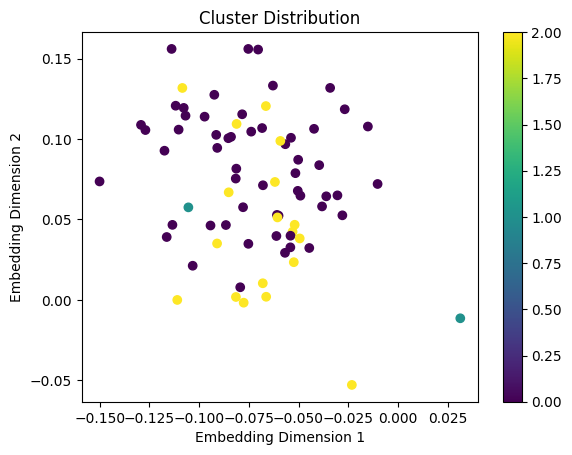

In [14]:
# Main script with user input
if __name__ == "__main__":
    print("Welcome to the LORD of the Gaps!")
    query = input("Enter your research query (e.g., 'machine learning AND healthcare'): ")
    max_results = int(input("Enter the maximum number of papers to retrieve (default 100): "))
    n_clusters = int(input("Enter the number of clusters for grouping (default 5): "))

    xml_data = fetch_arxiv_data(query, max_results)
    if xml_data:
        papers = parse_arxiv_response(xml_data)
        print(f"\nRetrieved {len(papers)} papers.")

        # Generate embeddings
        embeddings = generate_embeddings(papers)

        # Perform clustering
        labels = cluster_papers(embeddings, n_clusters=n_clusters)

        # Perform topic modeling
        topics = topic_modeling(papers, num_topics=n_clusters)
        print("\nIdentified Topics:")
        for idx, topic in enumerate(topics):
            print(f"Topic {idx}: {topic}")

        # Identify knowledge gaps
        identify_gaps(labels, papers)

        # Visualize clusters
        visualize_clusters(labels, embeddings)